<h1 style='color:#1B127A;'>
Introduction
</h1>

This notebook is used to study calculation of variance, covariance and variogram between two variables that are not necessarily from spatial context.

$E\{X\} = m_X = \bar{X}$

$Var(X) = \sigma^2_x = E\{ (X - \bar{X}^2)\} = \{X^2\} - \bar{X}^2$

$Cov\{X, Y\} = \sigma_{XY}= E\{ [X - \bar{X}] [Y - \bar{Y}]\} = \{XY\} - \bar{X}\bar{Y}$

$2\gamma_{XY} = E\{(X-Y)^2\}$


As can be seen above, both covariance and variogram can be defined for any two paired (equally sampled) random variables. Covariance is of great significance because it informs the optimal linear model that minimizes the squared error. This might be the main reason why covariance and correlation coefficient are measures of linear relationship. 

Variogram is a measure of variability in contrast to covariance that is a measure of similarity. Using variogram in geostatistics is partly historical and also due to the ease of calculation since there is no need to know the first moment (mean) of the two variables. As a result,variogram is dependent to linear transformation including translation or scaling while, variance and covariance are onlye affacted by scaling. Of course, the correlation coefficient (i.e. covariance after standardization) is not affected by linear transformation. This is shown in this notebook.


In general, the variogram of two random variables depends on their mean value and covariance.


$2\gamma_{XY} = \sigma^2_x + \sigma^2_y + (m_X - m_Y)^2 - 2\sigma_{XY} $


In spatial context, where the variogram is calculated between a variable and its lagged instance, the first and second order stationarity simplifies the relation ship since $m_x=m_y$, $\sigma^2_x = \sigma^2_y = C(0)$ and $\sigma_{XY} = C(h)$.

$\gamma_{XY} = C(0) - C(h) $

where $C(0)$ is the variogram sill i.e. variance (or any arbitrary large value that can be filtered out from estimation equations).



In [1]:
import pygeostat as gs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams

gs.PlotStyle['font.size'] = 16

<h1 style='color:#1B127A;'>
Helper Functions
</h1>

In [2]:
@gs.set_plot_style
def get_stats(data, translate=[0,0], scale=[1,1], plot = True):
    
    n_var = data.ndim
    
    if n_var != 2:
        raise ValueError('Only two variables are acceptable')
    
    if (len(translate) != n_var) or (len(scale) != n_var):
        raise ValueError('translation or scale must match the number of dimension')
        
    x = scale[0]*(data.values[:,0]+translate[0]); y = scale[1]*(data.values[:,1]+translate[1])
    cov = np.cov(x,y); 
    rho= np.corrcoef(x,y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    gamma = 0.5* np.mean((x-y)**2)
    cov_calc = (cov[0][0] + cov[1][1] + (mean_x-mean_y)**2  - 2*gamma)/2
    
    print('Mean: {:.2f} {:.2f}'.format(*[mean_x, mean_y]))
    print('Variance: {:.2f} {:.2f}'.format(*[cov[0,0], cov[1,1]]))
    print('Covariance: {:.2f}'.format(cov[1,0]))
    print('Correlation Coefficient: {:.2f}'.format(rho[1,0]))
    print('Semi-Variogram: {:.2f}'.format(gamma))
    print('Calculated Covariance {:.2f}'.format(cov_calc))
    
    if plot:
        # plot scatter plot and distance from 45 degree line
        fig, axes =plt.subplots(1,2, figsize=(15,7))
        frac = min(1000/len(data), 1.0)
        data_vis = data.sample(frac=frac)
        x = data_vis.values[:,0]; y = data_vis.values[:,1]
        _ = gs.scatter_plot(x, y, ax=axes[0], xlabel=data_vis.columns[0], ylabel=data_vis.columns[1])
        gamma = 0.5*(x-y)**2
        axes[1].scatter(x,y, c=gamma, cmap='jet')
        axes[1].set_xlabel(data_vis.columns[0], fontsize=16)
        axes[1].set_ylabel(data_vis.columns[1], fontsize=16)
        axes[1].set_title('Semi variogram (moment from the 45 degree line)', fontsize=16)
        
        
def create_sample_data(n_sample = 100000,
                      mean= np.array([0, 0, 0, 0]),
                      cov = np.array([[1, 0.8, -0.6, 0.4],
                                      [0.8, 1, -0.5, 0.6],
                                      [-0.6, -0.5, 1, -0.4],
                                      [0.4, 0.6, -0.4, 1]])):
    
    cov_inv = np.linalg.inv(cov)
    n_mv_samples = np.random.multivariate_normal(mean, cov, n_sample).T

    data=pd.DataFrame(dtype=np.float32)
    variables = []
    for i, variable in enumerate(n_mv_samples):
        var_name = 'Variable%i'%(i+1)
        variables.append(var_name)
        data[var_name] = variable
        
    return data

<h1 style='color:#1B127A;'>
Mean, Variance, Covariance and Variogram
</h1>


<h2 style='color:#5177F9;'>
Sampling two correlated random variables
</h2>

Two random variables are sampled from a bivariate Gaussian distribution and the mean, variance, covariance and variogram are calculated. Then, effect of translation and scaling on the mentioned statistics is evaluated.

Note that for the firs example, the two variables have the same mean and variance to satisfy the first and second order stationarity. The calculated covariance is calculated from variogram.

In [3]:
data= create_sample_data(mean = [10, 10], cov = [[1, 0.5], [0.5, 1.0]], n_sample=1000)
data.head()

,Variable1,Variable2
0,10.542206,9.715922
1,11.706538,10.684556
2,9.444505,9.308448
3,9.025046,8.564242
4,10.384349,12.464916


Mean: 9.96 10.01
Variance: 1.01 1.06
Covariance: 0.53
Correlation Coefficient: 0.51
Semi-Variogram: 0.51
Calculated Covariance 0.53


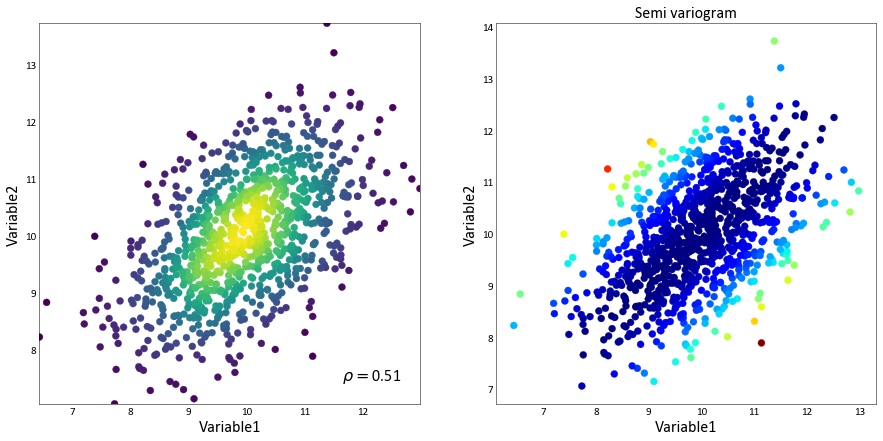

In [4]:
 get_stats(data)

<h2 style='color:#5177F9;'>
Effect of translation
</h2>

As shown below and obvious from mathematical derivations, mean and variogram are affected by translation. However, variance and covariance are not affected as they are quantified based on deviation from the mean (location of the distribution). Although the variogram is changed (due to change in th mean values), the covariance calculated from vraiogram remains the same.

Mean: 9.94 7.01
Variance: 1.42 1.95
Covariance: 0.51
Correlation Coefficient: 0.30
Semi-Variogram: 5.46
Calculated Covariance 0.51


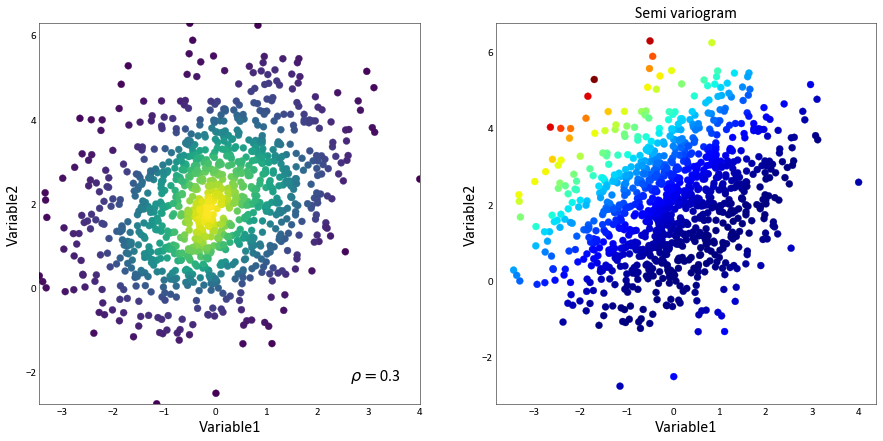

In [8]:
get_stats(data, translate=[10, 5], scale=[1, 1])

<h2 style='color:#5177F9;'>
Effect of scaling
</h2>

Scaling affects all statistics and yet the relationship between variogram and covariance is valid.

Mean: 21.92 33.03
Variance: 4.02 9.52
Covariance: 3.16
Correlation Coefficient: 0.51
Semi-Variogram: 65.35
Calculated Covariance 3.17


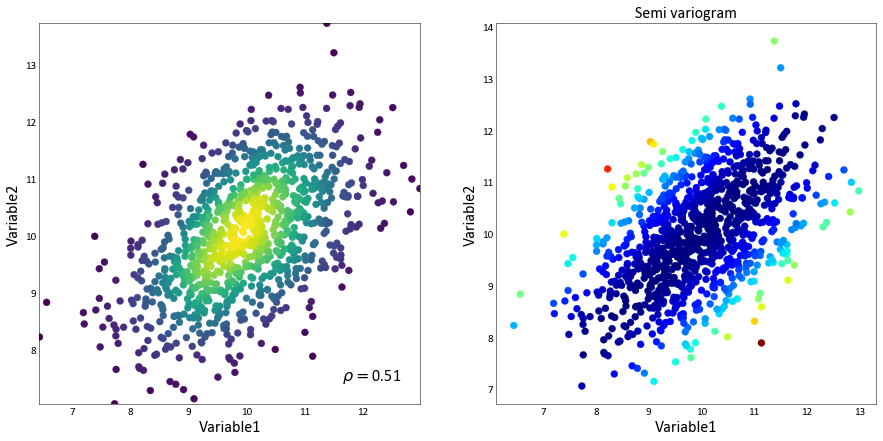

In [6]:
get_stats(data, translate=[1, 1], scale=[2, 3])

<h2 style='color:#5177F9;'>
Different mean and variance
</h2>

When the two variables have different mean/variance, variogram and covariance are still related using the equation below.

$2\gamma_{XY} = \sigma^2_x + \sigma^2_y + (m_X - m_Y)^2 - 2\sigma_{XY} $

However, due to non-stationarity (i.e. different first and second moment for the head and tail variables), the relationship cannot be reduced to the form below.

$\gamma_{XY} = C(0) - C(h) $

Note that stationarity is critical for linear model of co-regionalization that is based on modeling the spatial variability/continuity as a linear combination of a common pool of random variables or nested structures. As a result in a non-stationary domain e.g. a domain with a trend (a model of local mean), in order to us the linear model of regionalization (variogram model) and calculate the covariance, it is required to calculate and estimate residuals. Also, the variogram needs to be calculated and modeled for the residuals. The trend model can be re-introduced post spatail interpolation (i.e. kriging).

Mean: -0.06 2.01
Variance: 1.42 1.95
Covariance: 0.51
Correlation Coefficient: 0.30
Semi-Variogram: 3.33
Calculated Covariance 0.51


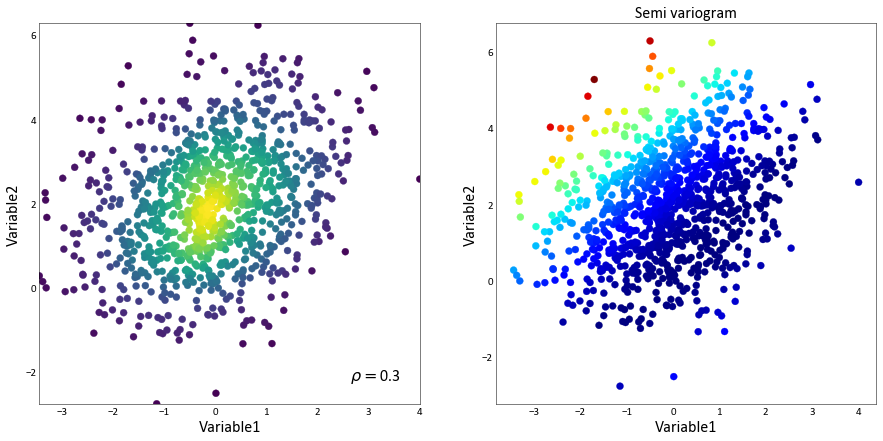

In [7]:
data= create_sample_data(mean = [0, 2], cov = [[1.5, 0.5], [0.5, 2.0]], n_sample=1000)
get_stats(data)